# Synthetic Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

from utils import CustomEarlyStopping, EarlyStoppingByLossVal
from _iwn import IWN

## Network

In [2]:
def get_estimator(input_shape=2):
    model = Sequential(name="weighter")
    model.add(Dense(100, activation="relu", input_shape=(input_shape,)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation=None))
    return model

## Setup

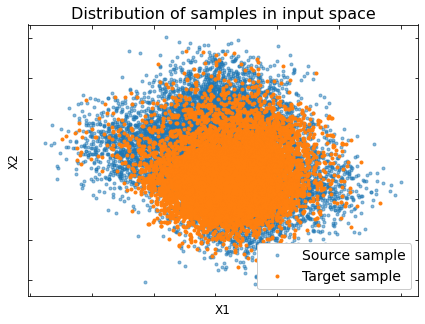

In [4]:
np.random.seed(1)
seeds = np.random.choice(2**16, 10)

N = 32
M = 10
m = 10000
n = 10000
perc = 0.2

prob = [perc] + [(1-perc) / (M-1)] * (M-1)
alphas = np.random.choice(M, m, p=prob)
betas = np.zeros((alphas.size, M))
betas[np.arange(alphas.size), alphas] = 1

mus = np.random.randn(M, N) #- 1
coefs = np.random.randn(M, N)

Xs = np.random.randn(m, N)*0.5 + betas.dot(mus)
Xt = np.random.randn(int(n*0.8), N)*0.5 + mus[0]
Xt = np.concatenate((Xt, np.random.randn(int(n*0.1), N)*0.5 + mus[1]), axis=0)
Xt = np.concatenate((Xt, np.random.randn(int(n*0.1), N)*0.5 + betas[(alphas!=0)&(alphas!=1)][:int(n*0.1)].dot(mus)), axis=0)

def f(x, w):
    return np.mean(w*x, 1)

ys = f(Xs, betas.dot(coefs))
yt = f(Xt, coefs[0])

np.random.seed(seeds[0])

plt.figure(figsize=(7, 5))
plt.plot(Xs[:, 0], Xs[:, 1], ".", alpha=0.5, label="Source sample")
plt.plot(Xt[:, 0], Xt[:, 1], ".", label="Target sample")
plt.legend(loc='lower right', framealpha=1, fontsize=14)

plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.tick_params(direction ='in', axis='both', top='on', bottom='on', left='on', right='on')
plt.title("Distribution of samples in input space", fontsize=16)
plt.xlabel("X1", fontsize=12)
plt.ylabel("X2", fontsize=12)

plt.show()

## Training

In [6]:
fit_params = dict(epochs=100, batch_size=256, verbose=1)
pretrain_params = dict(pretrain__epochs=40, pretrain__callbacks=[EarlyStoppingByLossVal(value=1e-3)])

iwn = IWN(get_estimator(), optimizer=Adam(0.001), **pretrain_params)
weights = iwn.fit_weights(Xs, Xt, **fit_params)

Epoch 1/40
40/40 [==============================] - 1s 3ms/step - loss: 0.2638
Epoch 2/40
40/40 [==============================] - 0s 3ms/step - loss: 0.2018
Epoch 3/40
40/40 [==============================] - 0s 3ms/step - loss: 0.1643
Epoch 4/40
40/40 [==============================] - 0s 3ms/step - loss: 0.1294
Epoch 5/40
40/40 [==============================] - 0s 3ms/step - loss: 0.1013
Epoch 6/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 7/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 8/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0507A: 0s - loss: 0.050
Epoch 9/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0429
Epoch 10/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 11/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0328
Epoch 12/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0291
Epoch 13/40
40/40 [===========

## Evaluation

In [9]:
model = Ridge()
model.fit(Xs, ys)
score = mean_absolute_error(yt, model.predict(Xt).ravel())
print("Target MAE without IW: %.3f"%score)

model = Ridge()
model.fit(Xs, ys, sample_weight=weights/weights.mean())
score = mean_absolute_error(yt, model.predict(Xt).ravel())
print("Target MAE with IW: %.3f"%score)

MAE without IW: 0.084
MAE with IW: 0.064


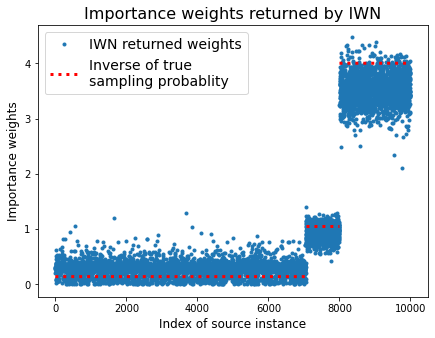

In [12]:
plt.figure(figsize=(7, 5))

index_0 = alphas==0
index_1 = alphas==1
index_2 = ((alphas!=0)&(alphas!=1))

weights /= weights.mean()
plt.plot(np.concatenate((weights[index_2], weights[index_1], weights[index_0])), ".", label="IWN returned weights")

plt.plot(np.arange(index_2.sum()), (0.1*len(Xs) / index_2.sum())*np.ones(index_2.sum()),
         c="red", ls=":", lw=3., label="Inverse of true \nsampling probablity")
plt.plot(np.arange(index_2.sum(), index_2.sum()+index_1.sum()), (0.1*len(Xs) / index_1.sum())*np.ones(index_1.sum()),
         c="red", ls=":", lw=3.)
plt.plot(np.arange(index_2.sum()+index_1.sum(), len(Xs)), (0.8*len(Xs) / index_0.sum())*np.ones(index_0.sum()),
         c="red", ls=":", lw=3.)

plt.legend(fontsize=14, loc="upper left")
plt.title("Importance weights returned by IWN", fontsize=16)
plt.xlabel("Index of source instance", fontsize=12)
plt.ylabel("Importance weights", fontsize=12)
plt.show()